## Validate the AB pair PPDF calculation

### Imports

In [1]:
import sys
sys.path.insert(0, '..')
import pymatcal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Read in the configuration. 
The configuration read-in routine should already been tested by `get_config.ipynb`

In [2]:
config = pymatcal.get_config('configs/pairs_ppdf.yml')

### Formula
$$a_{ij}= \frac{1}{N_j}\sum_{i' \in i}\sum_{j' \in j}\frac{\Omega_{i'j'}}{4\pi} \cdot e^{-\int_{L_s}^{L_p} \mu(l)dl}\left(1-e^{-\int_{L_p}^{L_q} \mu(l)dl}\right)$$

+ $N_j$ is the number of sub-elements in $j_{\textit{th}}$ source voxel.
+ $\Omega_{i'j'}$ s the solid angle of $i_{\textit{th}}'$ sub-element in the detector to $j_{\textit{th}}'$ sub-element in the image volumn(or FOV).
+ $L_s$ is the position of source $j'_{\textit{th}}$ sub-voxel on line L.
+ $L_p$ is the position of the photon incident on the $i'_{\textit{th}}$ sub-element in the detector.
+ $L_q$ is the position of the photon exit from $i'_{\textit{th}}$ sub-element in the detector.
+ $\mu(l)$ is the linear attenuation coefficient.

### Get point A
A index is 85

In [3]:
pointA=pymatcal.get_img_voxel_center(85, config['img nvx'], config['mmpvx'])
print('point A:',pointA)

point A: [ 0. 30.  0.]


### Show active detectors

In [4]:
print("Number of active detector units:",config['active dets'].shape[0])
print(config['active dets'])

Number of active detector units: 2
[[11.   21.   21.   27.   -0.5   0.5   5.    0.48]
 [ 0.   10.    9.   15.   -0.5   0.5   2.    0.48]]


### Setup subdivisions pairs
We pick the first active detector in the test

In [5]:
det_subdivs = pymatcal.get_det_subdivs(
    config['active dets'][0], config['det nsub'])
img_subdivs = pymatcal.get_img_subdivs(config['mmpvx'], config['img nsub'])
pAs = img_subdivs['coords']+pointA
pBs = pymatcal.get_centroids(det_subdivs['geoms'])
pAs = pymatcal.coord_transform(
    pymatcal.get_mtransform(config['angle'], -config['dist'], 5), pAs)
abpairs = pymatcal.get_AB_pairs(pAs, pBs)

### Set the objects geometry used in the ray tracing
A depreciated way is to:
1. Set blocking detector units array 

    ```Python
    blocks = config["det geoms"][config["det geoms"][:,6] != config["active dets"][0][6]]
    ```
2. Set the focused detector unit 
    ```Python
    focus_det = np.array([config["active det"][0]])
    ```
This is abandoned due to the fact that for each subdivision pairs, the blocking detector units and the focused detector unit are different.

Instead, we can tell if it is the focused (detecting) detector unit by looking at the $t$ number. If $t_1 = 1$, this intersection is in the detecting detector unit. Thus, we want the intersection calculation function to return $t_1$ for each $p_A p_B$ pair

### Get intersections
1. Append focused detector unit subdivisions to the objects geometry list.

In [6]:
geoms = pymatcal.append_subdivs(config['det geoms'],config['active dets'][0],det_subdivs['geoms'])

2. Calculate the intersections and intersects parameter $t$

In [7]:
ret = pymatcal.get_intersections_2d(geoms,abpairs)

3. Assign line segments for absorption and attenuation based on $t$ value.

3.1. Get the line segments indices for absorption and attenuation based on $t$ value 

In [8]:
idx_absorp = ret['ts'][:,:,1] == 1
idx_attenu = ret['ts'][:,:,1] != 1

3.2. Get segments lengths and the summation of the respective lengths for absorption and attenuation  

In [9]:

segs_absorp = np.where(idx_absorp,ret['intersections'],0)
segs_attenu = np.where(idx_attenu,ret['intersections'],0)
lensum_absorp = np.sum(segs_absorp,axis=0)
lensum_attenu = np.sum(segs_attenu,axis=0)


### Plot the rays without any attenuation

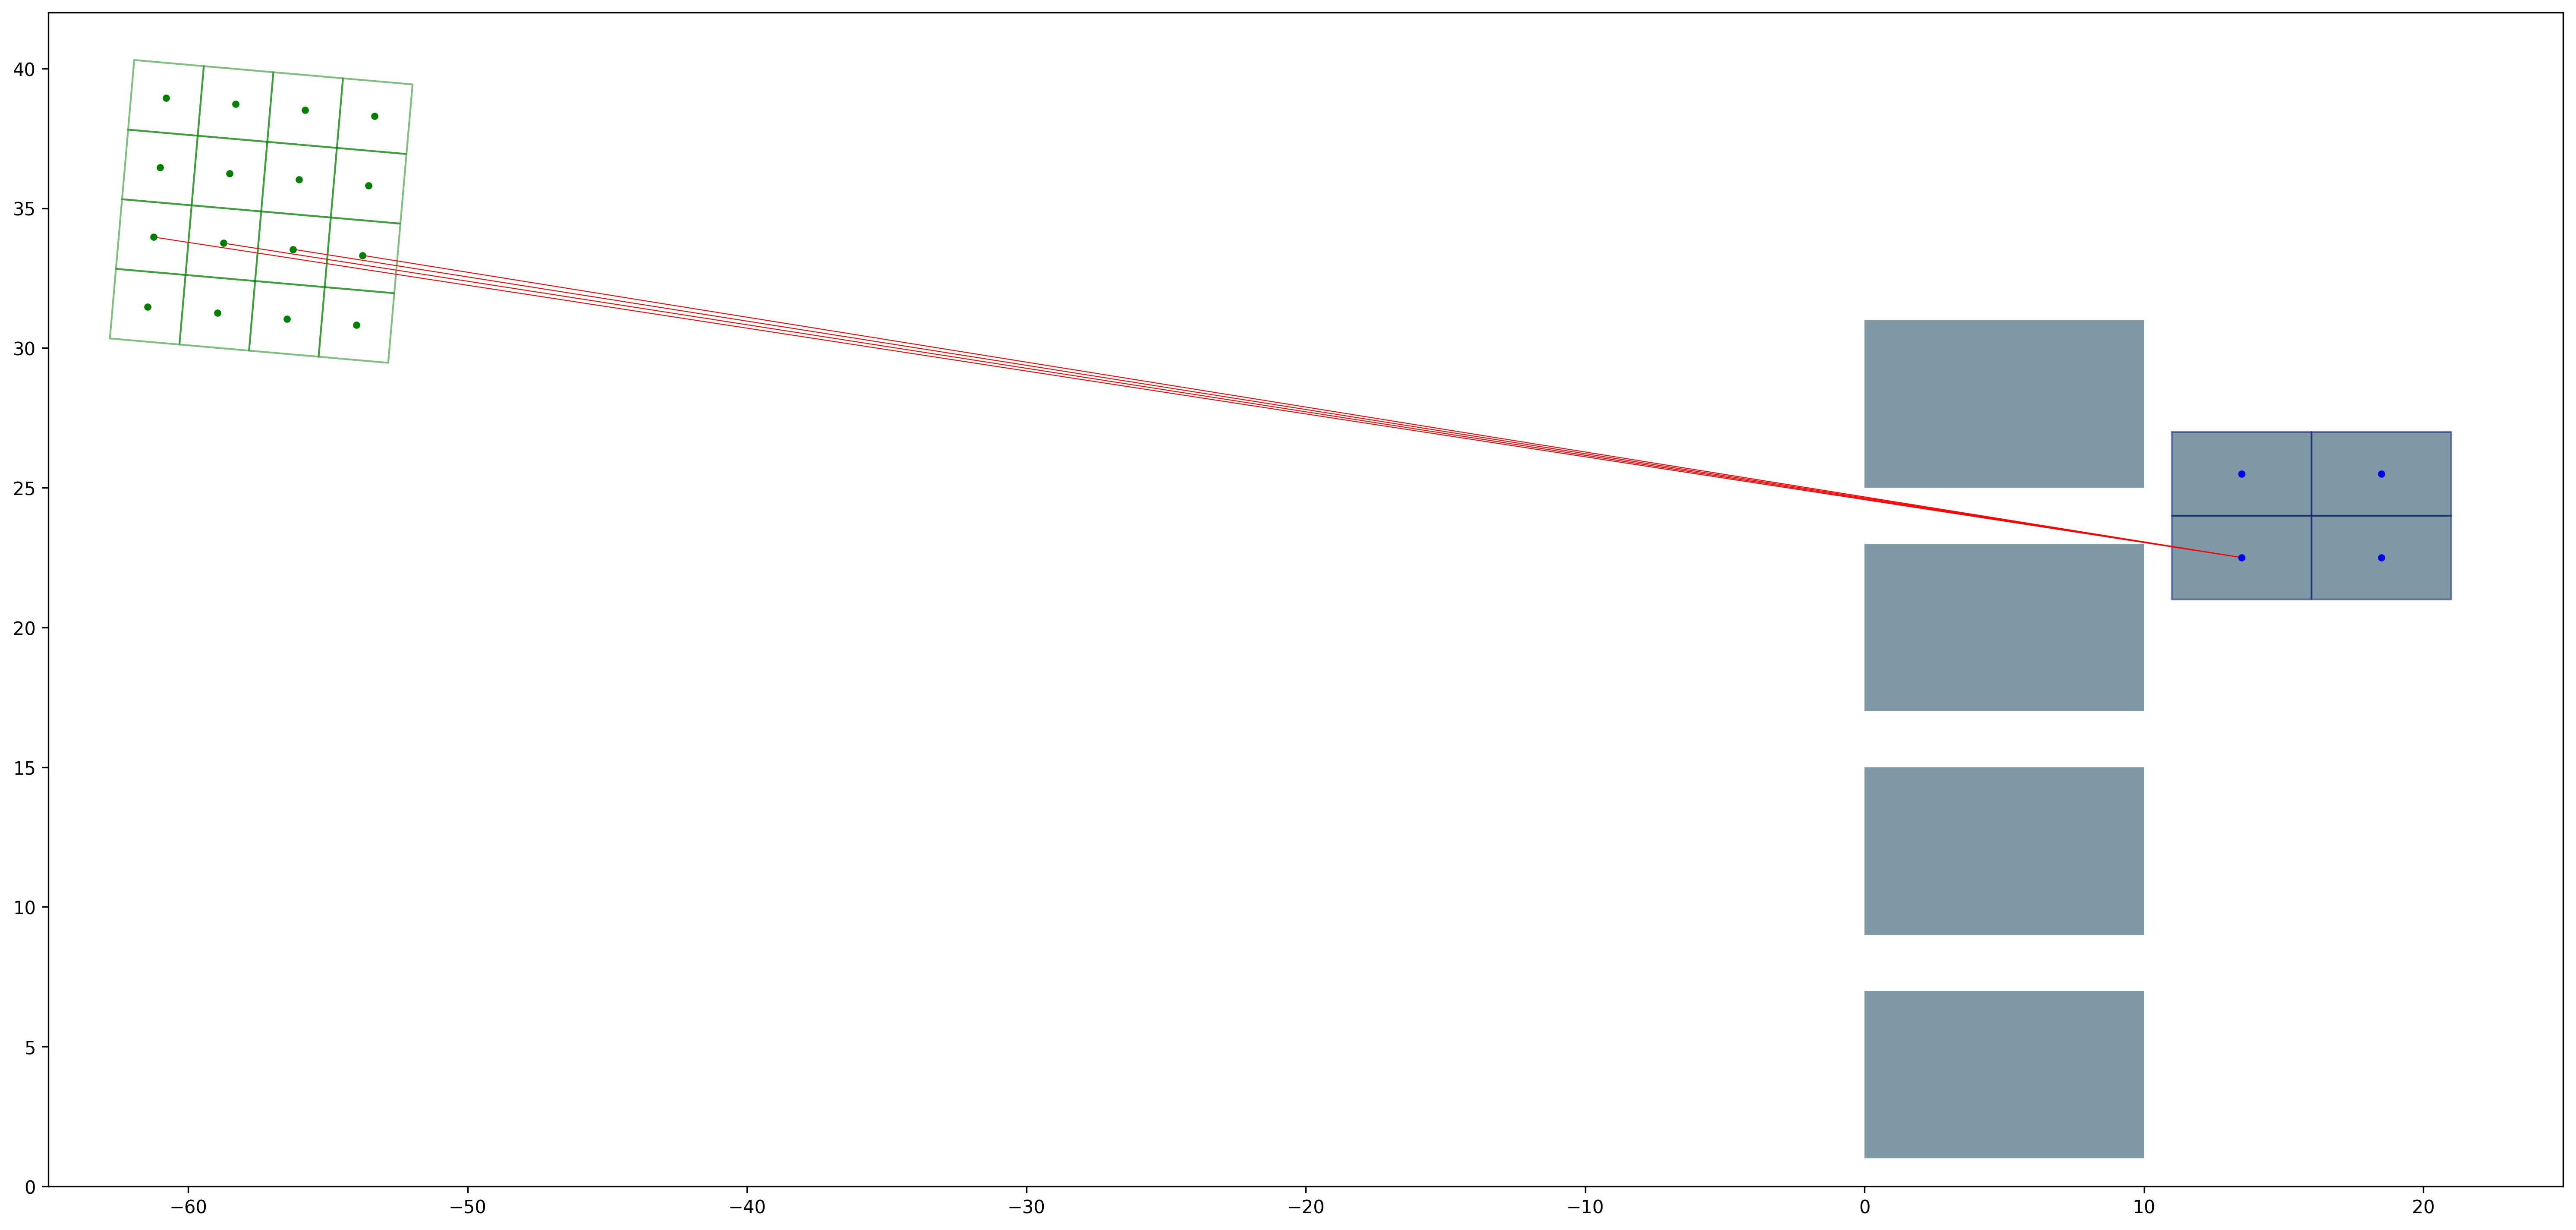

In [10]:
det_subdiv_list = [
    mpl.patches.Rectangle(
        xy[:2] - det_subdivs["incs"][:2] * 0.5,
        det_subdivs["incs"][0],
        det_subdivs["incs"][1],
    )
    for xy in pBs
]
subdiv_inc = np.array(
    [
        config["mmpvx"][0] / config["img nsub"][0],
        config["mmpvx"][1] / config["img nsub"][1],
    ]
)
img_subdiv_list = [
    mpl.patches.Rectangle(
        xy - subdiv_inc * 0.5,
        subdiv_inc[0],
        subdiv_inc[1],
        angle=-config['angle'],
        rotation_point=(xy[0], xy[1]),
    )
    for xy in pAs[:, :2]
]

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
pc = mpl.collections.PatchCollection(
    img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc="none")
pc1 = mpl.collections.PatchCollection(
    det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc="none")

passIndx = lensum_attenu == 0
# passIndx = lensum_absorp == 0
idx = 0
for pair in abpairs[passIndx]:
# for pair in abpairs:
    ax.plot(pair[0::3], pair[1::3], "-", c="r", ms=10, lw=0.5, zorder=12)
    idx += 1

block_list = [
    mpl.patches.Rectangle((geom[0], geom[2]),
                          geom[1] - geom[0], geom[3] - geom[2])
    for geom in config["det geoms"]
]
pc2 = mpl.collections.PatchCollection(
    block_list, fc=(0, 0.2, 0.3, 0.5), ec="none", zorder=10
)
ax.add_collection(pc2)
ax.plot(pAs[:, 0], pAs[:, 1], ".", color=(0, 0.5, 0, 1), ms=6, zorder=15)
ax.plot(pBs[:, 0], pBs[:, 1], ".", color=(0, 0, 1, 1), ms=6, zorder=15)
pAs_mins = np.min(pAs, axis=0)
pAs_maxs = np.max(pAs, axis=0)
det_mins = np.min(config["det geoms"], axis=0)
det_maxs = np.max(config["det geoms"], axis=0)
ax.set_xlim(-65, 25)
ax.set_ylim(0, 42)

ax.add_collection(pc)
ax.add_collection(pc1)
ax.set_aspect("equal")
fig.tight_layout()

### Get solid angles
No divided by $4\pi$

In [11]:
subdivs_sa = pymatcal.get_solid_angles(abpairs,det_subdivs['incs'])

### Finally, assemble the parts together
- Formula
$$a_{ij}= \frac{1}{N_j}\sum_{i' \in i}\sum_{j' \in j}\frac{\Omega_{i'j'}}{4\pi} \cdot e^{-\int_{L_s}^{L_p} \mu(l)dl}\left(1-e^{-\int_{L_p}^{L_q} \mu(l)dl}\right)$$

+ $N_j$ is the number of sub-elements in $j_{\textit{th}}$ source voxel.
+ $\Omega_{i'j'}$ s the solid angle of $i_{\textit{th}}'$ sub-element in the detector to $j_{\textit{th}}'$ sub-element in the image volumn(or FOV).
+ $L_s$ is the position of source $j'_{\textit{th}}$ sub-voxel on line L.
+ $L_p$ is the position of the photon incident on the $i'_{\textit{th}}$ sub-element in the detector.
+ $L_q$ is the position of the photon exit from $i'_{\textit{th}}$ sub-element in the detector.
+ $\mu(l)$ is the linear attenuation coefficient.

In [12]:
term_attenu = np.exp(-np.sum(segs_attenu.T*geoms[:, 7], axis=1))
term_absorp = 1-np.exp(-np.sum(segs_absorp.T*geoms[:, 7], axis=1))
term_solida = subdivs_sa /(4*np.pi)
ab_rays_ppd = term_attenu*term_absorp*term_solida

In [13]:
print('PPDF of Ray-AB',np.sum(ab_rays_ppd)/np.prod(config['img nsub']))

PPDF of Ray-AB 3.0269533789749555e-05


### Some estimations

In [14]:
print('term attenuation mean:',np.mean(term_attenu))
print('term absorption mean :',np.mean(term_absorp))
print('term solid angle mean:',np.mean(term_solida))
print('term means product   :',np.mean(term_attenu)*np.mean(term_absorp)*np.mean(term_solida)*4)

term attenuation mean: 0.18685442758860682
term absorption mean : 0.7030805120686514
term solid angle mean: 5.379400271003313e-05
term means product   : 2.8268470122203368e-05
